In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
import xgboost as xgb
import numpy as np
from collections import Counter
from geopy.distance import great_circle
import matplotlib.dates as dates
from sklearn import preprocessing 

In [2]:
#import files
calendar_summary_file="berlin-airbnb-data/calendar_summary.csv"
calendar_summary=pd.read_csv(calendar_summary_file)
listings_summary_file="berlin-airbnb-data/listings_summary.csv"
listings_summary=pd.read_csv(listings_summary_file)
listings_file="berlin-airbnb-data/listings.csv"
listings=pd.read_csv(listings_file)
neighbourhoods_file="berlin-airbnb-data/neighbourhoods.csv"
neighbourhoods=pd.read_csv(neighbourhoods_file)
reviews_summary_file="berlin-airbnb-data/reviews_summary.csv"
reviews_summary=pd.read_csv(reviews_summary_file)
reviews_file="berlin-airbnb-data/reviews.csv"
reviews=pd.read_csv(reviews_file)

In [3]:
def data_summary(x):
    print(x.head())
    print(x.describe())
    print(x.shape)
    print(x.columns)
    print(x.duplicated().sum())

In [4]:
#to get summary of every file
data_summary(calendar_summary)
data_summary(listings_summary)
data_summary(listings)
data_summary(neighbourhoods)
data_summary(reviews_summary)
data_summary(reviews)

   listing_id        date available price
0        2015  2019-09-10         f   NaN
1        2015  2019-09-09         f   NaN
2        2015  2019-09-08         f   NaN
3        2015  2019-09-07         f   NaN
4        2015  2019-09-06         f   NaN
         listing_id
count  8.231480e+06
mean   1.571560e+07
std    8.551880e+06
min    2.015000e+03
25%    8.065954e+06
50%    1.686638e+07
75%    2.258393e+07
max    2.986735e+07
(8231480, 4)
Index(['listing_id', 'date', 'available', 'price'], dtype='object')
0
     id                        listing_url       scrape_id last_scraped  \
0  2015  https://www.airbnb.com/rooms/2015  20181107122246   2018-11-07   
1  2695  https://www.airbnb.com/rooms/2695  20181107122246   2018-11-07   
2  3176  https://www.airbnb.com/rooms/3176  20181107122246   2018-11-07   
3  3309  https://www.airbnb.com/rooms/3309  20181107122246   2018-11-07   
4  7071  https://www.airbnb.com/rooms/7071  20181107122246   2018-11-07   

                                  

0
     id                                              name  host_id host_name  \
0  2015  Berlin-Mitte Value! Quiet courtyard/very central     2217       Ian   
1  2695                Prenzlauer Berg close to Mauerpark     2986   Michael   
2  3176                   Fabulous Flat in great Location     3718    Britta   
3  3309                 BerlinSpot Schöneberg near KaDeWe     4108      Jana   
4  7071                  BrightRoom with sunny greenview!    17391    Bright   

      neighbourhood_group             neighbourhood   latitude  longitude  \
0                   Mitte           Brunnenstr. Süd  52.534537  13.402557   
1                  Pankow  Prenzlauer Berg Nordwest  52.548513  13.404553   
2                  Pankow   Prenzlauer Berg Südwest  52.534996  13.417579   
3  Tempelhof - Schöneberg           Schöneberg-Nord  52.498855  13.349065   
4                  Pankow            Helmholtzplatz  52.543157  13.415091   

         room_type  price  minimum_nights  number_of_r

In [5]:
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

In [6]:
listings_summary_pre = listings_summary[columns_to_keep].set_index('id')
listings_summary_pre.shape
listings_summary_pre.head(3)

,space,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,square_feet,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
id,,,,,,,,,,,,,,,,,,,,,
2015,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,...,NaN,$60.00,$30.00,$200.00,$28.00,1,4,f,f,strict_14_with_grace_period
2695,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,...,NaN,$17.00,$0.00,$0.00,$0.00,1,2,f,f,flexible
3176,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,...,720.0,$90.00,$50.00,$200.00,$20.00,2,62,t,f,strict_14_with_grace_period


In [7]:
listings_summary_pre.room_type.value_counts(normalize=True) #analyze room_type available

Private room       0.511440
Entire home/apt    0.475435
Shared room        0.013125
Name: room_type, dtype: float64

In [8]:
listings_summary_pre.property_type.value_counts(normalize=True) #analyze property_type available

Apartment                 0.896816
Condominium               0.027137
Loft                      0.020397
House                     0.017648
Serviced apartment        0.007760
Hostel                    0.005676
Townhouse                 0.004390
Guest suite               0.003281
Bed and breakfast         0.002838
Guesthouse                0.002527
Hotel                     0.002217
Other                     0.002084
Boutique hotel            0.001907
Bungalow                  0.000887
Boat                      0.000754
Tiny house                0.000532
Houseboat                 0.000488
Camper/RV                 0.000488
Villa                     0.000443
Aparthotel                0.000310
Pension (South Korea)     0.000310
Cabin                     0.000266
Cottage                   0.000177
Resort                    0.000133
Castle                    0.000089
Casa particular (Cuba)    0.000089
Train                     0.000089
Cave                      0.000044
Tipi                

In [9]:
listings_summary_pre[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)



,price,cleaning_fee,extra_people,security_deposit
id,,,,
2015,$60.00,$30.00,$28.00,$200.00
2695,$17.00,$0.00,$0.00,$0.00
3176,$90.00,$50.00,$20.00,$200.00


In [10]:
#which column has null values
print(listings_summary_pre.price.isna().sum())
print(listings_summary_pre.cleaning_fee.isna().sum())
print(listings_summary_pre.extra_people.isna().sum())
print(listings_summary_pre.security_deposit.isna().sum())

0
7146
0
9361


In [11]:
#Remove null values
listings_summary_pre.cleaning_fee.fillna('$0.00', inplace=True)
print(listings_summary_pre.cleaning_fee.isna().sum())
listings_summary_pre.security_deposit.fillna('$0.00', inplace=True)
print(listings_summary_pre.security_deposit.isna().sum())

0
0


In [13]:
#Removing $ and converting to float
# listings_summary_pre.price = listings_summary_pre.price.astype(str).str.replace('$', '').str.replace(',', '').astype(float)
# listings_summary_pre.cleaning_fee = listings_summary_pre.cleaning_fee.astype(str).str.replace('$', '').astype(float)
# listings_summary_pre.security_deposit = listings_summary_pre.security_deposit.astype(str).str.replace('$', '').astype(float)
# listings_summary_pre.extra_people = listings_summary_pre.extra_people.astype(str).str.replace('$', '').astype(float)



In [14]:
listings_summary_pre.price.describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

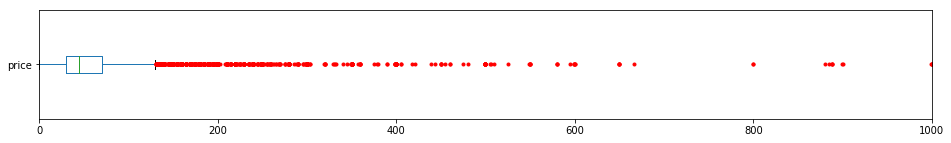

In [15]:
#box plot of price
#see that most values are upto 150 but max is 1000 
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
listings_summary_pre['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2))


In [16]:
#Drop rows having price greater than 400
listings_summary_pre.drop(listings_summary_pre[ (listings_summary_pre.price > 400) | (listings_summary_pre.price == 0) ].index, axis=0, inplace=True)
listings_summary_pre.price.describe()

count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

In [17]:
#null values of every column
listings_summary_pre.isna().sum()


space                            8503
description                       202
host_has_profile_pic               25
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     21996
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [18]:
#drop cols with many nas
listings_summary_pre.drop(columns=['square_feet', 'space'], inplace=True)
listings_summary_pre.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

In [19]:
#replacing null value of host_has_profile_pic with 'f'
listings_summary_pre.host_has_profile_pic.unique()
listings_summary_pre.host_has_profile_pic.fillna(value='f', inplace=True)
listings_summary_pre.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [20]:
listings_summary_pre.isna().sum()

description                     202
host_has_profile_pic              0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
dtype: int64

In [21]:
results = Counter()
listings_summary_pre['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Wifi', 21372),
 ('Kitchen', 21216),
 ('Heating', 21073),
 ('Essentials', 20211),
 ('Washer', 18395),
 ('Hair dryer', 14793),
 ('Laptop friendly workspace', 14374),
 ('Hangers', 13814),
 ('Iron', 11121),
 ('Shampoo', 10572),
 ('TV', 10026),
 ('Hot water', 9676),
 ('Family/kid friendly', 8082),
 ('Internet', 7862),
 ('Host greets you', 6634),
 ('Smoke detector', 6396),
 ('Buzzer/wireless intercom', 6080),
 ('Lock on bedroom door', 5256),
 ('Refrigerator', 5173),
 ('Free street parking', 5170),
 ('Dishes and silverware', 5046),
 ('Elevator', 4805),
 ('Cooking basics', 4803),
 ('Bed linens', 4801),
 ('Stove', 4781),
 ('Smoking allowed', 4568),
 ('Oven', 4283),
 ('translation missing: en.hosting_amenity_50', 4170),
 ('First aid kit', 3967),
 ('Cable TV', 3683)]

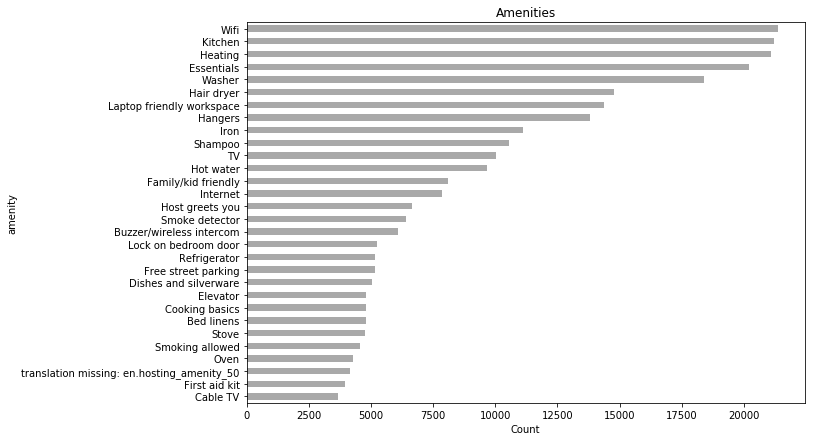

In [22]:
#plot a graph of houses with most common amenities. 
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');





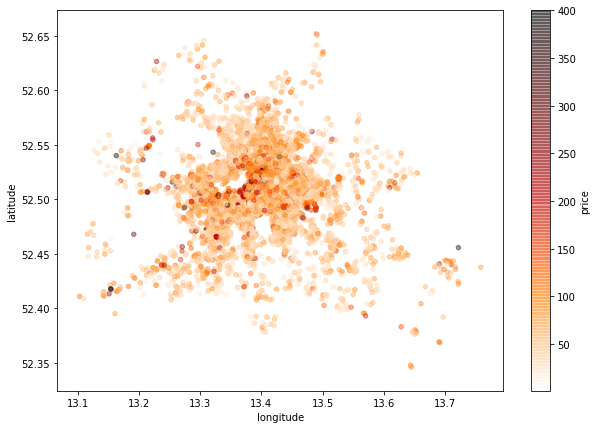

In [23]:
#scatter plot of houses based on geographical distances. 

listings_summary_pre.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

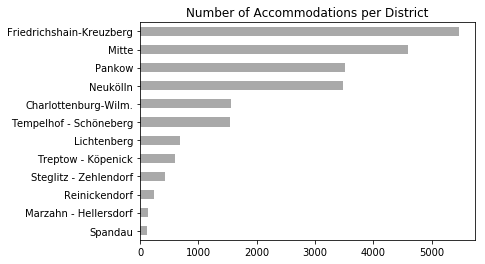

In [24]:
#Bar graph of houses on neighbourhood_group_cleansed. 

listings_summary_pre['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District');



In [25]:
listings_summary_pre.neighbourhood_group_cleansed.value_counts(normalize=True)



Friedrichshain-Kreuzberg    0.244250
Mitte                       0.205038
Pankow                      0.157251
Neukölln                    0.155822
Charlottenburg-Wilm.        0.069983
Tempelhof - Schöneberg      0.068733
Lichtenberg                 0.030369
Treptow - Köpenick          0.026484
Steglitz - Zehlendorf       0.019427
Reinickendorf               0.010897
Marzahn - Hellersdorf       0.006253
Spandau                     0.005493
Name: neighbourhood_group_cleansed, dtype: float64

   neighbourhood_group_cleansed  price
0          Charlottenburg-Wilm.   49.0
1      Friedrichshain-Kreuzberg   48.0
2                   Lichtenberg   38.0
3         Marzahn - Hellersdorf   48.5
4                         Mitte   50.0
5                      Neukölln   40.0
6                        Pankow   50.0
7                 Reinickendorf   35.0
8                       Spandau   39.0
9         Steglitz - Zehlendorf   45.0
10       Tempelhof - Schöneberg   45.0
11           Treptow - Köpenick   43.0


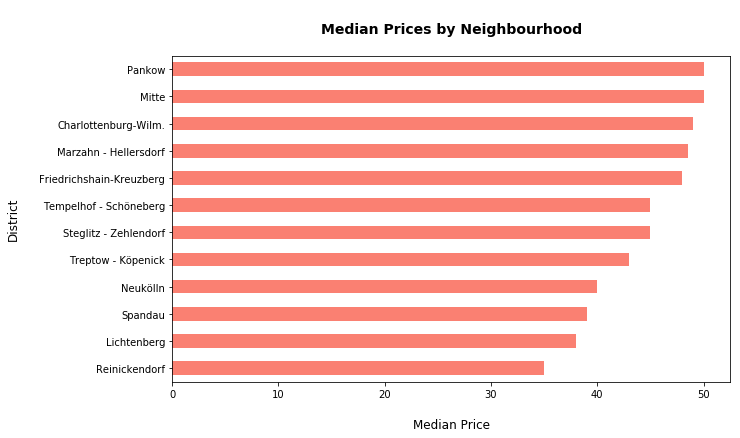

In [26]:
#Median Prices of houses based on Neighbourhood. 

df_grouped = pd.DataFrame(listings_summary_pre.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)
print(df_grouped)
# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');



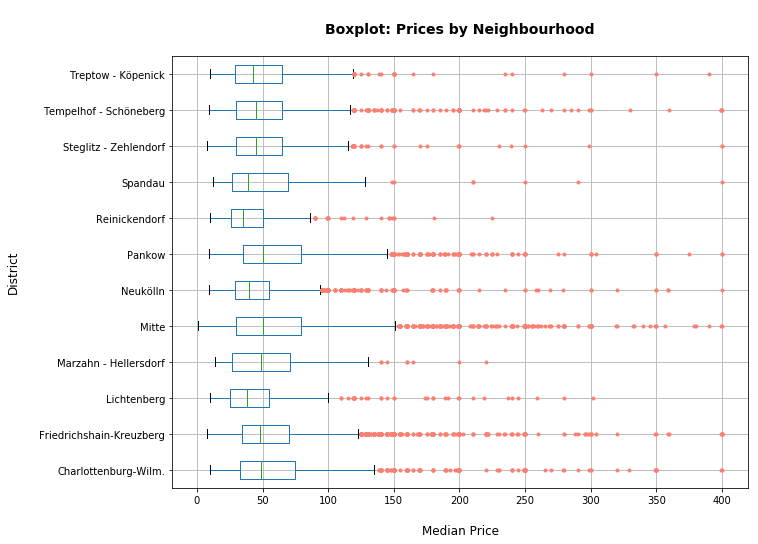

In [27]:
#Box plot of prices based on Neighbourhood
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

listings_summary_pre.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

In [28]:
#Function to calculate distance from Berlin
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km



In [29]:
#adding distance parameter
listings_summary_pre['distance'] = listings_summary_pre.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)



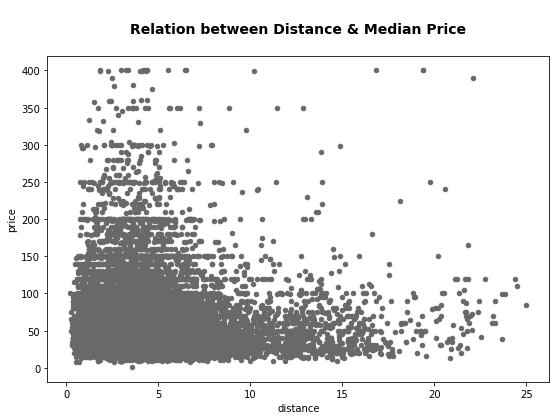

In [30]:
#analysing how price varies as distance
listings_summary_pre.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');



In [31]:
#to see how price affects time of year
calendar_summary.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [32]:
#converting availability to numerical values
label_encoder = preprocessing.LabelEncoder() 
calendar_summary.available= label_encoder.fit_transform(calendar_summary['available'])   

In [33]:
#covert date to integer values
calendar_summary.date=pd.to_datetime(calendar_summary.date)
calendar_summary.date = dates.date2num(calendar_summary.date)

In [34]:
calendar_summary.date

0          737312.0
1          737311.0
2          737310.0
3          737309.0
4          737308.0
5          737307.0
6          737306.0
7          737305.0
8          737304.0
9          737303.0
10         737302.0
11         737301.0
12         737300.0
13         737299.0
14         737298.0
15         737297.0
16         737296.0
17         737295.0
18         737294.0
19         737293.0
20         737292.0
21         737291.0
22         737290.0
23         737289.0
24         737288.0
25         737287.0
26         737286.0
27         737285.0
28         737284.0
29         737283.0
             ...   
8231450    737034.0
8231451    737033.0
8231452    737032.0
8231453    737031.0
8231454    737030.0
8231455    737029.0
8231456    737028.0
8231457    737027.0
8231458    737026.0
8231459    737025.0
8231460    737024.0
8231461    737023.0
8231462    737022.0
8231463    737021.0
8231464    737020.0
8231465    737019.0
8231466    737018.0
8231467    737017.0
8231468    737016.0
